In [1]:
cd ..

/home/martinsevilla/smoothness_langevin


### Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import pickle as pkl
import networkx as nx

from langevin import langevin as lang
import langevin.utils as ut

# np.set_printoptions(suppress=True)

plt.rcParams['figure.figsize'] = [6, 5]

plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize

mpl.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

torch.set_default_device("cuda")
torch.set_default_dtype(torch.float64)

%load_ext line_profiler
%load_ext autoreload
%autoreload 2

### Data creation

In [39]:
seed = 13
torch.manual_seed(seed)
np.random.seed(seed)

# EDP-GNN model
model_file = ("edp_gnn/exp/deezer_ego/edp-gnn_train_deezer_ego__Jun-14-14-14-11_1489048/models/" +
              "train_deezer_ego_[0.03, 0.08222222, 0.13444444, 0.18666667, 0.23888889, 0.29111111, 0.34333333, 0.39555556, 0.44777778, 0.5].pth")

# Adjacency matrix
with open("edp_gnn/data/test_deezer_ego.pkl", "rb") as f:
    graphs = pkl.load(f)
    g = graphs[np.random.randint(len(graphs))]
    A = nx.to_numpy_array(g, nodelist=np.random.permutation(g.nodes()))
    A = torch.tensor(A)

# A = torch.randint(0, 2, (5, 5)).double()
# A = torch.triu(A) + torch.triu(A, 1).T
# A.fill_diagonal_(0.0)

# Number of nodes
p = A.shape[0]
# Number of measurements
n = 10
# Filter parameter distribution
# theta_dist = torch.distributions.Normal(5, 0.005)
theta = 0.05 # theta_dist.sample()
# Variance of the noise
sigma_e = 1

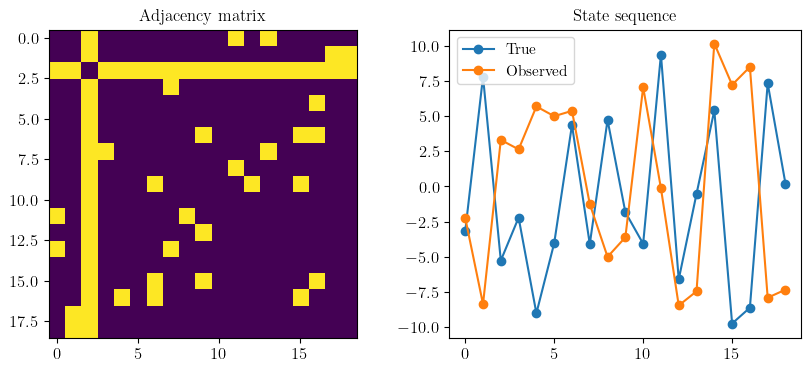

In [40]:
# Dynamics matrix
F = ut.heat_diffusion_filter(A, theta)
# L = ut.compute_laplacian(A)
e_dist = torch.distributions.Normal(0, sigma_e)

# Generate state and measurement sequence
X = torch.empty((p, n)).uniform_(-10, 10) # * torch.empty((p, n)).bernoulli_(0.8)
Y = F @ X + e_dist.sample((p, n))

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(A.cpu())
ax[0].set_title('Adjacency matrix')
ax[1].plot(X.T.cpu()[np.random.randint(n)], "-o", label="True")
ax[1].plot(Y.T.cpu()[np.random.randint(n)], "-o", label="Observed")
ax[1].set_title('State sequence')
ax[1].legend()
plt.show()

### KLF

In [41]:
sigmas = torch.linspace(0.5, 0.03, 10)
epsilon = 1.0E-6
steps = 100

model = ut.load_model(model_file)
A_score_model = ut.score_edp_wrapper(model, A.shape[0], len(sigmas), max_nodes=25)

langevin_est = lang.LangevinEstimator(h_theta=ut.heat_diffusion_filter,
                                      A_score_model=A_score_model,
                                    #   theta_prior_dist=theta_dist,
                                      theta_fixed=theta,
                                      sigma_e=sigma_e)

langevin_est.langevin_estimate(X=X, Y=Y, sigmas_sq=sigmas ** 2, epsilon=epsilon, steps=steps, temperature=0.5,
                               projection_method="copy", clip_A_tilde=True, true_A=A)

AUCROC: 0.8570143884892086


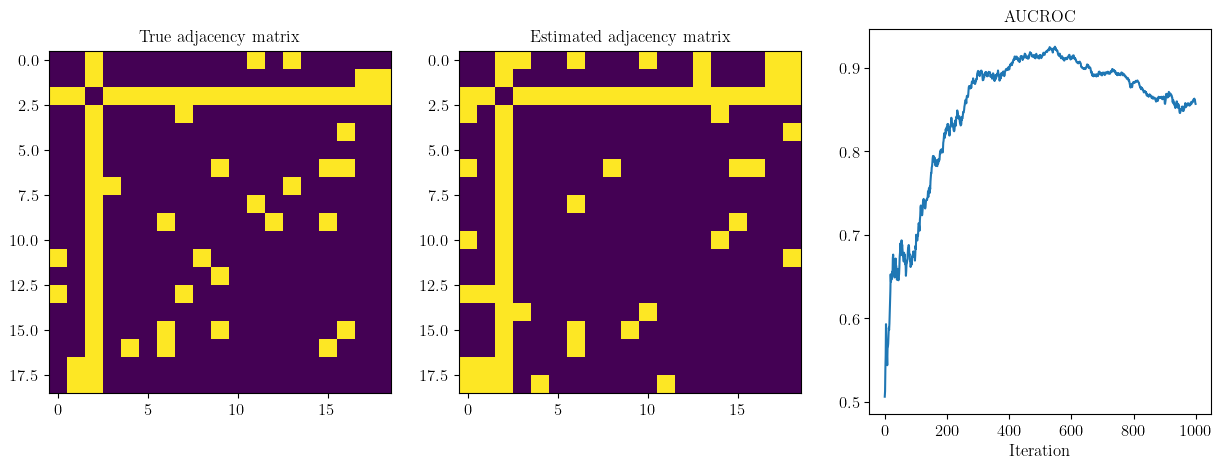

In [42]:
theta_est = langevin_est.theta_tilde
roc, threshold = ut.compute_aucroc(A, langevin_est.A_tilde, return_threshold=True)
A_est = (langevin_est.A_tilde > threshold).cpu().numpy()

# print("Real theta:", theta.item())
# print("Estimated theta:", theta_est)
print("AUCROC:", roc)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(A.cpu())
ax[0].set_title('True adjacency matrix')

ax[1].imshow(A_est)
ax[1].set_title('Estimated adjacency matrix')

ax[2].set_xlabel("Iteration")
ax[2].set_title("AUCROC")
ax[2].plot(langevin_est.metrics["aucroc"].cpu())

plt.show()

In [16]:
# %lprun -f klf.kalman_langevin_estimate klf.kalman_langevin_estimate(sigmas_sq=sigmas ** 2, epsilon=epsilon, steps=steps, temperature=1.0)